In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import io
from contextlib import redirect_stdout
import sys
sys.path.append("../scripts")


import data

%load_ext autoreload
%autoreload 2

german 0.07 42


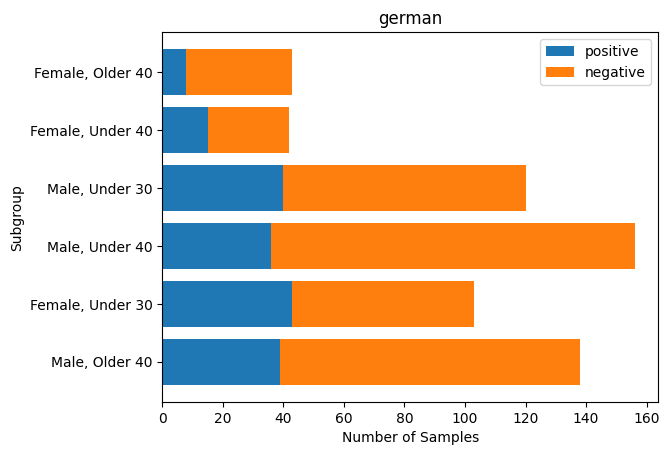

compas 0.06 277


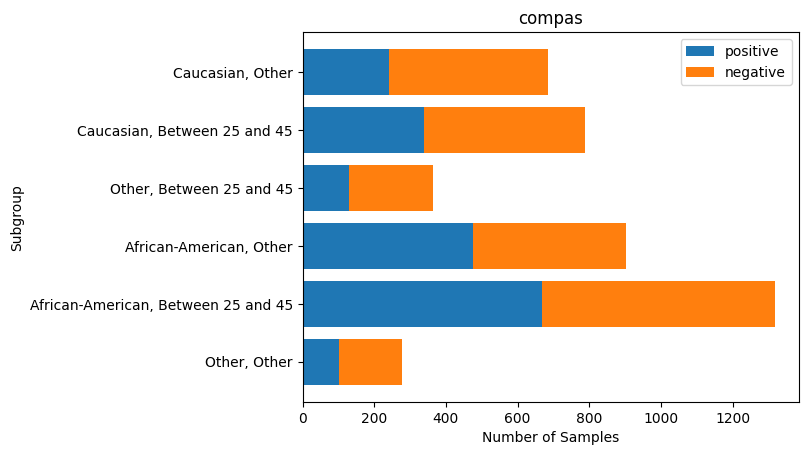

taiwan 0.11 1969


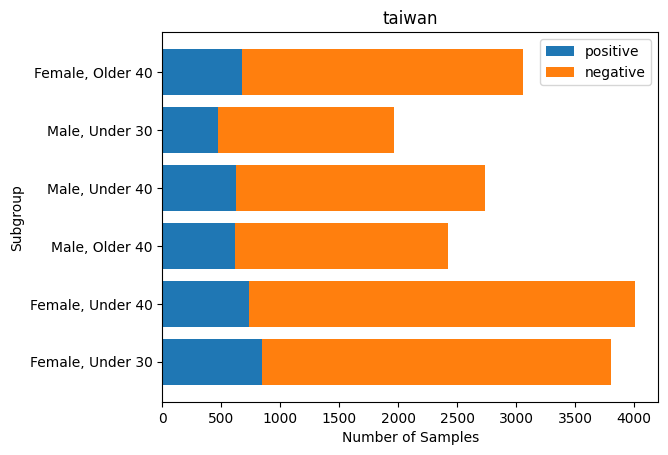

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


adult 0.08 2313


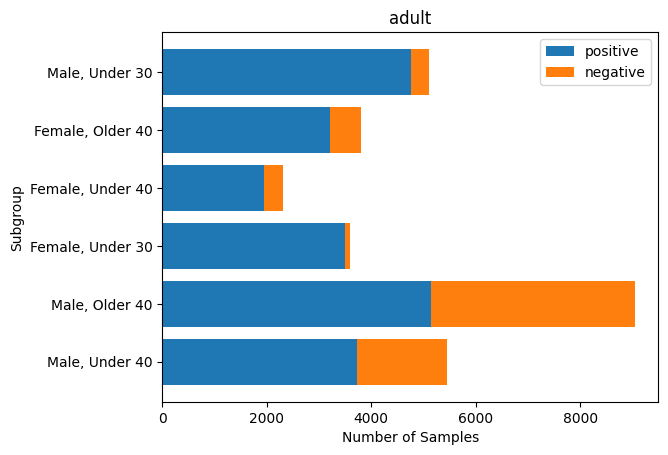

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [85] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


enem 0.07 2163


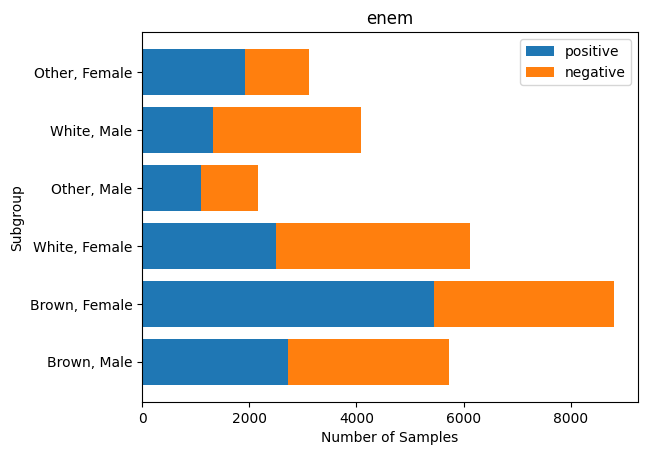

acsincome 0.04 40854


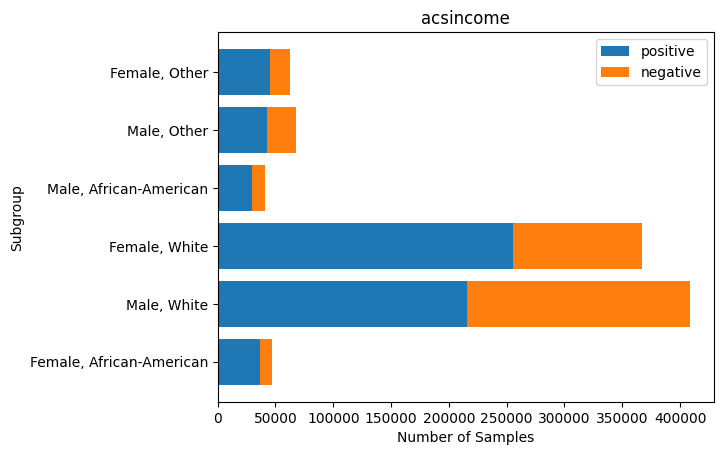

In [4]:
for dataset in ["german", "compas", "taiwan", "adult", "enem", "acsincome"]:
    f = io.StringIO() # to catch print
    with redirect_stdout(f):
        (
            X_train,
            A_train,
            Y_train,
            X_val,
            A_val,
            Y_val,
            X_test,
            A_test,
            Y_test,
        ) = data.get_strat_split(dataset, 6, 20, 0)
    groups_dict = literal_eval(f.getvalue())
    # invert dict
    groups_dict = {v: k for k, v in groups_dict.items()}

    groups = A_train.unique()
    groups_df = []
    for group in groups:
        groups_df.append({
            "group" : group,
            "size" : len(A_train[A_train == group]),
            "positive_size" : Y_train[A_train == group].sum(),
            "positive_rate" : Y_train[A_train == group].sum() / len(A_train),
            "prop" : len(A_train[A_train == group]) / len(A_train)
        })
    groups_df = pd.DataFrame(groups_df)
    groups_df["negative_size"] = groups_df["size"] - groups_df["positive_size"]
    groups_df["negative_rate"] = groups_df["prop"] - groups_df["positive_rate"]

    print(dataset, np.round(groups_df.prop.min(), 2), np.round(groups_df["size"].min()))
    fig, ax = plt.subplots()
    ax.barh(groups_df["group"], groups_df["negative_size"], label="positive")
    bottom = groups_df["negative_size"]
    ax.barh(groups_df["group"], groups_df["positive_size"], left=bottom, label="negative")
    ax.legend()
    ax.set_title(dataset)
    ax.set_xlabel("Number of Samples")
    ax.set_ylabel("Subgroup")
    ax.set_yticks(groups_df["group"])
    ax.set_yticklabels([groups_dict[group] for group in groups_df["group"]])
    plt.show()